# Asimov significance

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [10]:
# get lumi
import pickle as pkl
with open("../combine/templates/v6/hists_templates_Run2.pkl", "rb") as f:    
    h = pkl.load(f)

In [11]:
h

Hist(
  StrCategory(['VBF', 'Data', 'EWKvjets', 'Diboson', 'WH', 'WJetsLNu', 'TTbar', 'SingleTop', 'ggF', 'DYJets', 'QCD', 'WZQQ', 'ttH', 'ZH'], growth=True, name='Sample'),
  StrCategory(['nominal', 'weight_btagSFlightCorrelated_up', 'weight_btagSFlightCorrelated_down', 'weight_btagSFbcCorrelated_up', 'weight_btagSFbcCorrelated_down', 'weight_btagSFlight2016_up', 'weight_btagSFlight2016_down', 'weight_btagSFbc2016_up', 'weight_btagSFbc2016_down', 'weight_btagSFlight2016APV_up', 'weight_btagSFlight2016APV_down', 'weight_btagSFbc2016APV_up', 'weight_btagSFbc2016APV_down', 'weight_btagSFlight2017_up', 'weight_btagSFlight2017_down', 'weight_btagSFbc2017_up', 'weight_btagSFbc2017_down', 'weight_btagSFlight2018_up', 'weight_btagSFlight2018_down', 'weight_btagSFbc2018_up', 'weight_btagSFbc2018_down', 'weight_pileup_up', 'weight_pileup_down', 'weight_pileupIDSF_up', 'weight_pileupIDSF_down', 'weight_isolation_up', 'weight_isolation_down', 'weight_id_up', 'weight_id_down', 'weight_reco_ele_up'

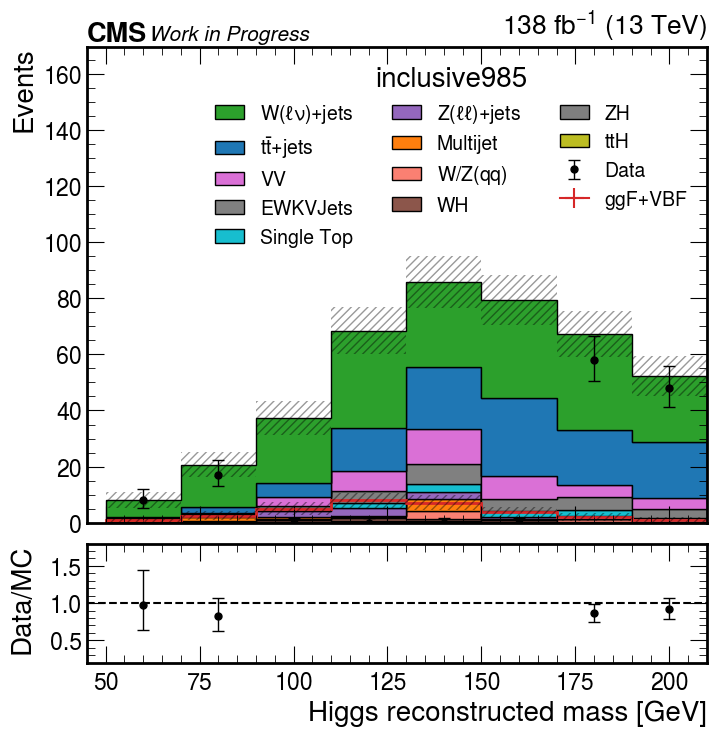

In [16]:
plt.rcParams.update({"font.size": 20})

region = "SR975to985"
region = "inclusive985"
text = region

blind_region=[90,160]
mult = 1

if "CR" in region:
    blind_region = False
    mult=1

years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]

from utilsCombine import plot_hists
from utilsCombine2 import plot_hists

plot_hists(h[{"Systematic": "nominal", "Region": region}], years, channels,
            add_data=True,
            logy=False,
            add_soverb=True,
            only_sig=False,
            mult=mult,
            outpath=f"/Users/fmokhtar/Desktop/AN_2024/combine/",
           save_as=region,
           text_=text,
           blind_region=blind_region,
          )

# ParT vs Part-Finetuned

In [99]:
# WP1
tagger_cuts_ParT = [
#     0.95,
#     0.955,
    0.96,
    0.965,
    0.97,
    0.975,
    0.98,
    0.985,
    0.99,
    0.995,
    0.999,
    0.9995,
    0.9999,    
]
sig_ParT = [
#     ,   # 0.95
#     ,   # 0.955
    0.290405,   # 0.96
    0.302361,   # 0.965    
    0.397358,   # 0.97
    0.456074,   # 0.975    
    0.506333,   # 0.98
    0.547189,   # 0.985
    0.591012,   # 0.99
    0.659842,   # 0.995
    0.852163,   # 0.999   
    0.751642,   # 0.9995
    0.281329,   # 0.9999
]

tagger_cuts_ParT_finetuned = [
#     0.95,
#     0.955,
    0.96,
    0.965,
    0.97,
    0.975,
    0.98,
    0.985,
]
sig_ParT_finetuned = [
#     ,   # 0.95
#     ,   # 0.955
    1.10156,   # 0.96
    1.12463,   # 0.965    
    1.26753,   # 0.97
    1.52741,   # 0.975    
    1.55333,   # 0.98
    1.45807,   # 0.985  
]

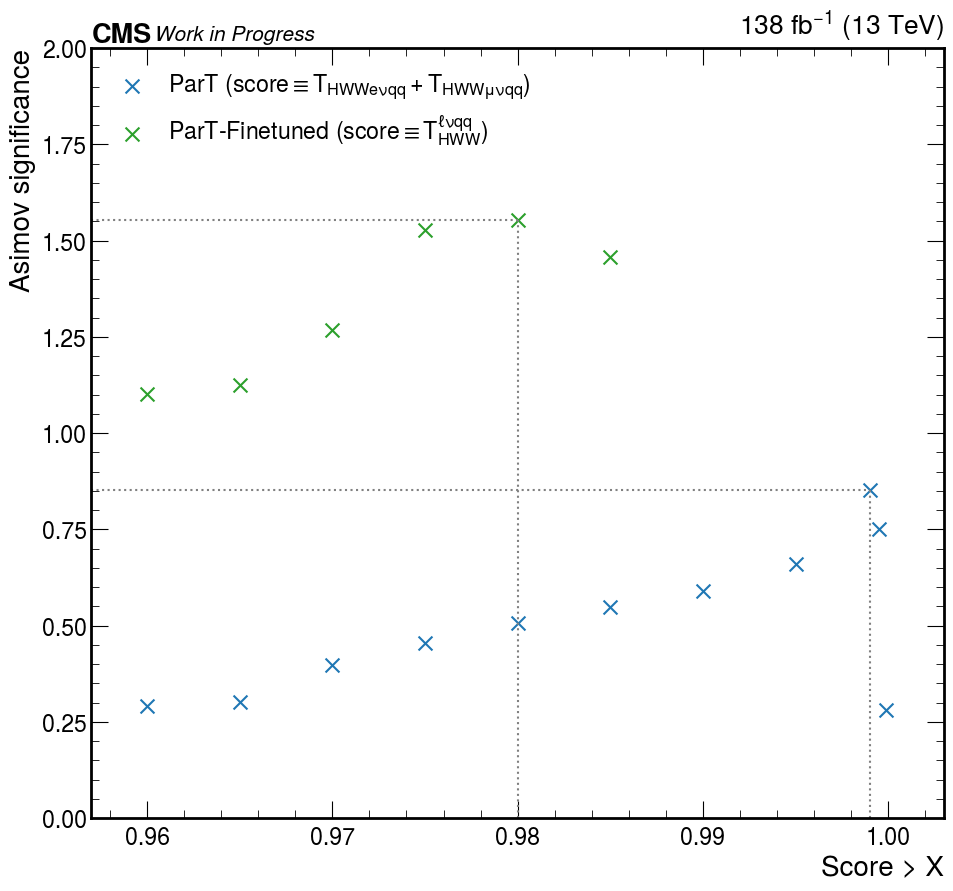

In [101]:
color_dict = {    
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:green",   
}

lab_dict = {    
    "fj_ParT_score": r"ParT ($score \equiv T_{HWW e \nu q q} +T_{HWW \mu \nu q q}$)",
    "fj_ParT_score_finetuned": r"ParT-Finetuned ($score \equiv T_{HWW}^{\ell\nu qq}$)",
}


plt.rcParams.update({"font.size": 20})


years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(11, 10))


ax.scatter(tagger_cuts_ParT, sig_ParT, marker="x", s=100, label=lab_dict["fj_ParT_score"], color=color_dict["fj_ParT_score"])    
ax.scatter(tagger_cuts_ParT_finetuned, sig_ParT_finetuned, marker="x", s=100, label=lab_dict["fj_ParT_score_finetuned"], color=color_dict["fj_ParT_score_finetuned"])

# ax.axhline(1.50482, color="grey", linestyle="--")
# ax.axhline(0.882643, color="grey", linestyle="--")

ax.set_ylim(0.3, 1.8)
ax.legend(loc="upper left")
ax.set_ylabel("Asimov significance")
ax.set_xlabel("Score > X")

x1 = 0.957
y1 = 0
ax.set_xlim(x1, 1.003)
ax.set_ylim(y1, 2)

####### ParT
wp = 0.999
sig = 0.852163
ax.plot([wp, wp], [y1, sig], ':', color='grey')
ax.plot([x1, wp], [sig, sig], ':', color='grey')

####### ParT_finetuned
wp = 0.98
sig = 1.55333
ax.plot([wp, wp], [y1, sig], ':', color='grey')
ax.plot([x1, wp], [sig, sig], ':', color='grey')

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/significance/sig_ParTvsParTFinetuned.pdf")

# Should we categorize?

In [102]:
# WP1
tagger_cuts = [
#     0.95,
#     0.955,
    0.96,
    0.965,
    0.97,
    0.975,
    0.98,
    0.985,
#     0.99,
]

# with ggF and VBF splitting
sig_ggFandVBF = [
#     ,   # 0.95
#     ,   # 0.955
    1.69683,   # 0.96
    1.72527,   # 0.965    
    1.87312,   # 0.97
    1.94273,   # 0.975    
    1.95343,   # 0.98
    2.01982,   # 0.985
#     0,   # 0.99    
]

# without ggF and VBF splitting
sig = [
#     ,   # 0.95
#     ,   # 0.955
    1.10156,   # 0.96
    1.12463,   # 0.965    
    1.26753,   # 0.97
    1.52741,   # 0.975    
    1.55333,   # 0.98
    1.45807,   # 0.985 
#   ,   # 0.99
]

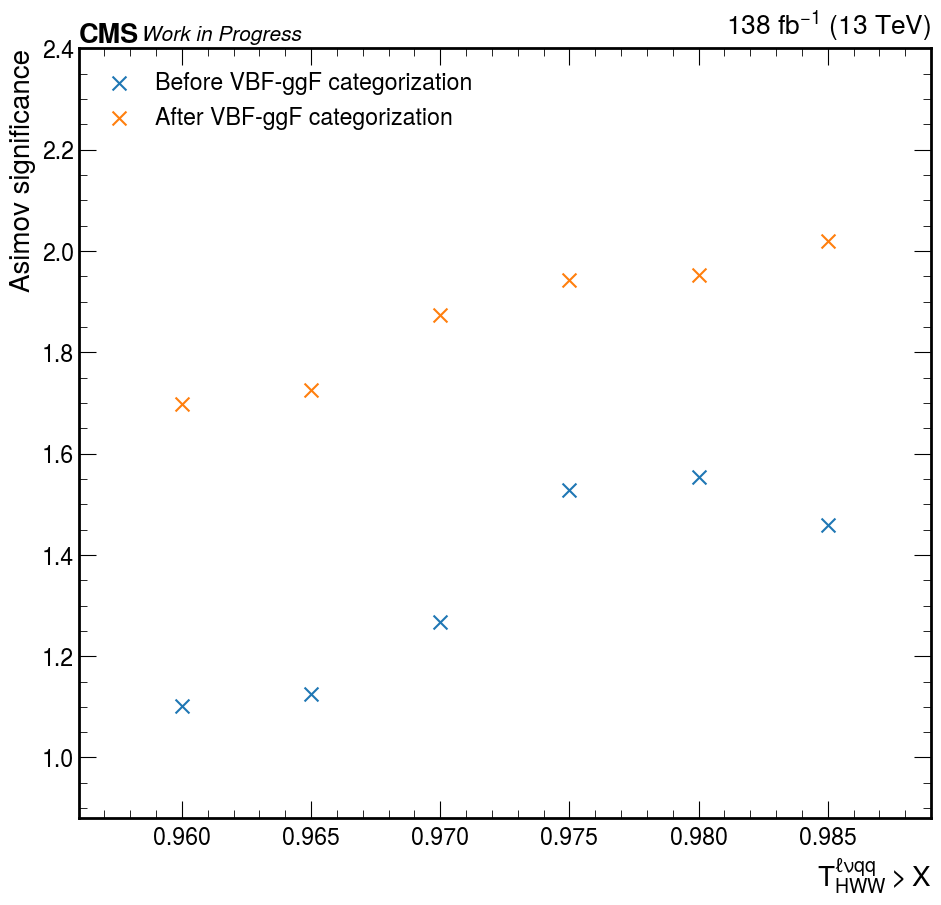

In [103]:
color_dict = {    
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:green",   
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})

years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(11, 10))

ax.scatter(tagger_cuts, sig, marker="x", s=100, label="Before VBF-ggF categorization")
ax.scatter(tagger_cuts, sig_ggFandVBF, marker="x", s=100, label="After VBF-ggF categorization")

# ax.plot([0.975, 0.975], [0.3, 2.00251], ':', color='grey')
# ax.plot([0.3, 0.975], [2.00251, 2.00251], ':', color='grey')

# ax.plot([0.985, 0.985], [0.3, 1.67914], ':', color='grey')
# ax.plot([0.3, 0.985], [1.67914, 1.67914], ':', color='grey')

ax.set_xlim(0.956, 0.989)
ax.set_ylim(0.88, 2.4)

# ax.set_ylim(0, 1.4)
ax.legend(loc="upper left")
ax.set_ylabel("Asimov significance")
ax.set_xlabel(r"$T_{HWW}^{\ell\nu qq} > X$")

# ax.set_xticks(tagger_cuts)

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/significance/significance_VBFggFcategorization.pdf")

# WP1 (ggF and VBF)

In [104]:
# WP1
# reading from combine for WP1
tagger_cuts = [
#     0.95,
#     0.955,    
    0.96,
    0.965,
    0.97,
    0.975,
    0.98,
    0.985,
#     0.99,
]
sig_vbf = [
#     ,   # 0.95
#     ,   # 0.955    
    1.41832,   # 0.96     
    1.45092,   # 0.965    
    1.54902,   # 0.97    
    1.4585,   # 0.975   
    1.46687,   # 0.98    
    1.61406 ,   # 0.985   
#     0, # 0.99
]
sig_ggf_inclusive = [
#     ,   # 0.95
#     ,   # 0.955    
    0.931825,   # 0.96
    0.943242,   # 0.965    
    1.05922,   # 0.97
    1.2807,   # 0.975
    1.28349,   # 0.98
    1.19507,   # 0.985    
#     1.02185, # 0.99
]
sig_ggf_pt250to300 = [
#     ,   # 0.95
#     ,   # 0.955    
    0.585655,   # 0.96
    0.596964,   # 0.965    
    0.698558,   # 0.97
    0.694796,   # 0.975    
    0.696016,   # 0.98
    0.649567,   # 0.985    
]
sig_ggf_pt300to450 = [
#     ,   # 0.95
#     ,   # 0.955    
    0.717493,   # 0.96
    0.725336,   # 0.965    
    0.800835,   # 0.97
    0.996255,   # 0.975    
    0.985146,   # 0.98
    0.916468,   # 0.985    
]
sig_ggf_pt450toInf = [
#     ,   # 0.95
#     ,   # 0.955    
    0.515151,   # 0.96
    0.529218,   # 0.965    
    0.552414,   # 0.97
    0.568887,   # 0.975    
    0.531955,   # 0.98
    0.498513,   # 0.985    
]

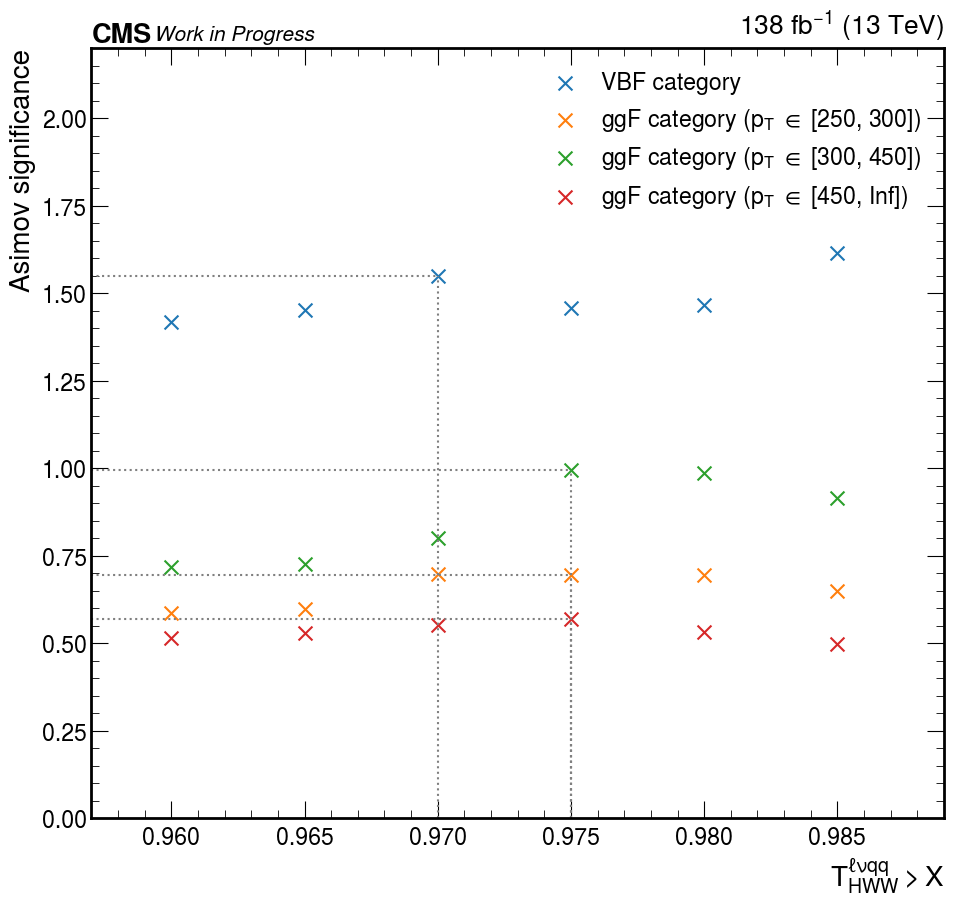

In [108]:
color_dict = {    
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:green",   
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})

years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(11, 10))

for tagger in [
#     "fj_ParT_score",
    "fj_ParT_score_finetuned",
]:
    ax.scatter(tagger_cuts, sig_vbf, marker="x", s=100, label="VBF category")
#     ax.scatter(tagger_cuts, sig_ggf_inclusive, marker="x", s=100, label="ggF category (all inclusive in pT)")
    ax.scatter(tagger_cuts, sig_ggf_pt250to300, marker="x", s=100, label=r"ggF category ($p_T$ $\in$ [250, 300])")
    ax.scatter(tagger_cuts, sig_ggf_pt300to450, marker="x", s=100, label=r"ggF category ($p_T$ $\in$ [300, 450])")
    ax.scatter(tagger_cuts, sig_ggf_pt450toInf, marker="x", s=100, label=r"ggF category ($p_T$ $\in$ [450, Inf])")               

    
x1 = 0.957
y1 = 0
ax.set_xlim(x1, 0.989)
ax.set_ylim(y1, 2.2)

####### VBF
wp = 0.97
sig = 1.54902
ax.plot([wp, wp], [y1, sig], ':', color='grey')
ax.plot([x1, wp], [sig, sig], ':', color='grey')

####### ggFpt250to300
wp = 0.975
sig = 0.694796
ax.plot([wp, wp], [y1, sig], ':', color='grey')
ax.plot([x1, wp], [sig, sig], ':', color='grey')

####### ggFpt300to450
wp = 0.975
sig = 0.996255
ax.plot([wp, wp], [y1, sig], ':', color='grey')
ax.plot([x1, wp], [sig, sig], ':', color='grey')

####### ggFpt450toInf
wp = 0.975
sig = 0.568887
ax.plot([wp, wp], [y1, sig], ':', color='grey')
ax.plot([x1, wp], [sig, sig], ':', color='grey')

ax.legend()
ax.set_ylabel("Asimov significance")
ax.set_xlabel(r"$T_{HWW}^{\ell\nu qq} > X$")

# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])

# ax.set_xticks(tagger_cuts)


hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/significance/significanceWP.pdf")